In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import missingno
dateparse = lambda dates: [datetime.datetime.strptime(d, '%d-%m-%Y %H:%M') for d in dates]
aod = pd.read_csv('Dataset/aod-csv/aod-jan-dec-2020.csv', parse_dates=['date'], dayfirst=True)
cpcb = pd.read_csv('Dataset/CPCB/cpcb-2020.csv', parse_dates=['From Date', 'To Date'], dayfirst=True)

In [2]:
cpcb[['PM2.5', 'RH', 'WS', 'SR', 'BP',
       'AT', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone']] = cpcb[['PM2.5', 'RH', 'WS', 'SR', 'BP',
       'AT', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone']].astype(float)
cpcb.dtypes

Unnamed: 0             int64
From Date     datetime64[ns]
To Date       datetime64[ns]
PM2.5                float64
RH                   float64
WS                   float64
SR                   float64
BP                   float64
AT                   float64
NO2                  float64
NOx                  float64
NH3                  float64
SO2                  float64
CO                   float64
Ozone                float64
Station               object
latitude             float64
longitude            float64
station id             int64
dtype: object

In [3]:
cpcb.keys()

Index(['Unnamed: 0', 'From Date', 'To Date', 'PM2.5', 'RH', 'WS', 'SR', 'BP',
       'AT', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Station', 'latitude',
       'longitude', 'station id'],
      dtype='object')

In [4]:
cpcb['DOYx'] = np.sin(2*np.pi*cpcb['From Date'].dt.dayofyear/365)
cpcb['DOYy'] = np.cos(2*np.pi*cpcb['From Date'].dt.dayofyear/365)
cpcb['x'] = np.cos(cpcb['latitude'])*np.cos(cpcb['longitude'])
cpcb['y'] = np.cos(cpcb['latitude'])*np.sin(cpcb['longitude'])
cpcb['z'] = np.sin(cpcb['latitude'])
cpcb['cardinal'] = cpcb['From Date'].dt.dayofyear

#https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature

In [5]:
def season(df):
    df['season'] = 0
    for i in [2018,2019,2020]:
        start_date = str(datetime.date(i, 1, 1))
        end_date =str(datetime.date(i,1 , 31))
        df.loc[df['From Date'].between(start_date, end_date), ['season'] ] = 1

        start_date = str(datetime.date(i, 2, 1))
        end_date =str(datetime.date(i,3 , 30))
        df.loc[df['From Date'].between(start_date, end_date), ['season'] ] = 2

        start_date = str(datetime.date(i, 7, 1))
        end_date =str(datetime.date(i,9 , 30))
        df.loc[df['From Date'].between(start_date, end_date), ['season'] ] = 3

        start_date = str(datetime.date(i, 10, 1))
        end_date =str(datetime.date(i,12 , 31))
        df.loc[df['From Date'].between(start_date, end_date), ['season'] ] = 4

    return df    

cpcb = season(cpcb).iloc[:,1:]

In [6]:
def data_merger(cpcb, aod):
    """
    cpcb: pandas dataframe containing CPCB data
    aod: pandas dataframe for preprocessed AOD data

    return doi: data of interest, with PM2.5 and AOD present in all rows. Other variables might have nan values.

    Note: aod should contain continuous data from one date to another. Should be sorted date wise.
    """
    try:
        doi = cpcb[['From Date', 'latitude', 'longitude', 'station id', 'season', 'DOYx', 'DOYy', 'x', 'y', 'z', 'cardinal'] + ['PM2.5', 'RH', 'WS', 'SR', 'BP', 'NO2', 'NOx', 'SO2', 'CO', 'Ozone', 'NH3', 'AT']]
    except:

        doi = cpcb[['From Date', 'latitude', 'longitude', 'station id', 'season', 'DOYx', 'DOYy', 'x', 'y', 'z', 'cardinal'] + ['PM2.5', 'RH', 'WS', 'SR', 'BP', 'NO2', 'NOx', 'SO2', 'CO', 'Ozone', 'NH3']]

    start_date = (aod['date'].loc[0])
    end_date = aod['date'].loc[aod.shape[0] -1]
    doi['From Date'] = doi['From Date'].dt.normalize()
    doi = doi[doi['From Date'].between(start_date, end_date)].reset_index(drop=True)
    aod = aod[pd.to_datetime(aod['date'], dayfirst=False).between(start_date, end_date)].reset_index(drop=True)
    doi = doi.sort_values(by=['From Date', 'station id'])
    doi = doi.reset_index(drop = True)
    aod = aod.reset_index(drop = True)
    doi[['AOD47', 'AOD47_3', 'AOD47_5', 'ColumnWV', 'AOD47_3var', 'AOD47_5var', 'AOD55']] = aod[['AOD47', 'AOD47_3', 'AOD47_5', 'ColumnWV', 'AOD47_3var', 'AOD47_5var', 'AOD55']]
    print((aod['latitude'].to_numpy() == doi['latitude'].to_numpy()).all())

   #imputation needed here
    doi.drop(doi[doi['AOD47'] == '--'].index, inplace= True)
    doi[['AOD47', 'AOD47_3', 'AOD47_5', 'ColumnWV', 'AOD47_3var', 'AOD47_5var', 'AOD55']]= doi[['AOD47', 'AOD47_3', 'AOD47_5', 'ColumnWV', 'AOD47_3var', 'AOD47_5var', 'AOD55']].astype(float)
    doi.drop(doi[doi['AOD47']==0].index, inplace=True)
    #doi.drop(doi[doi['PM2.5'].isna()].index, inplace=True)

    #doi.drop(doi[doi['AOD47']== 4].index, inplace=True)
    #doi.drop(doi[doi.isna().any(axis = 1) == True].index, inplace=True)

    return doi

def rolling(df):
    df['AOD47_timemean5'] = np.nan
    df['AOD47_timevar5'] = np.nan
    for i in range(1,41):
        df.loc[df['station id'] == i,['AOD47_timemean5'] ] = df['AOD47'].rolling(window = 5).mean()
        df.loc[df['station id'] == i, ['AOD47_timevar5']] =  df['AOD47'].rolling(window = 5).var()
    
    return df

df = (data_merger(cpcb, aod))

df.to_csv('Dataset/aod-pm2.5-csv/AOD_with_CWV-daily-2020.csv')



        

c:\Anaconda\envs\lazypredict\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True


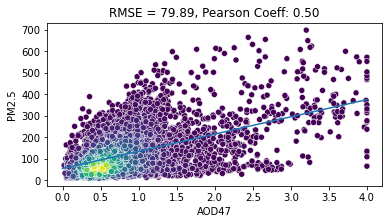

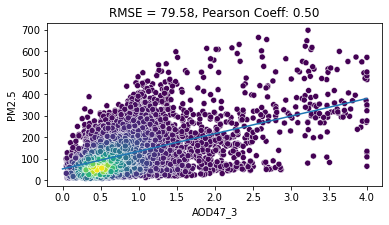

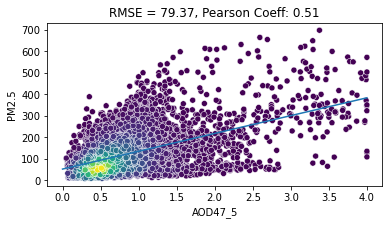

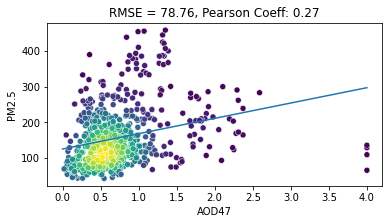

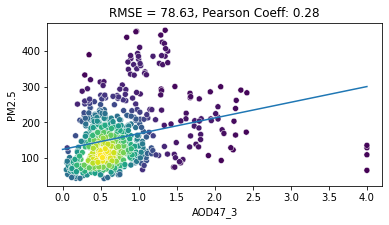

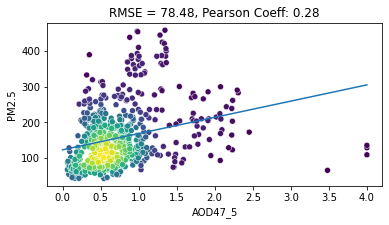

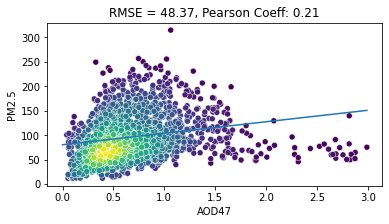

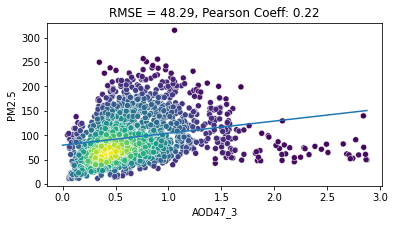

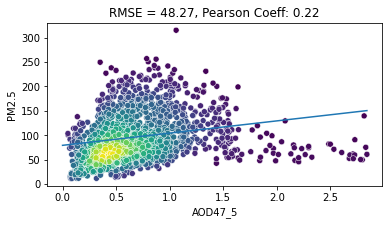

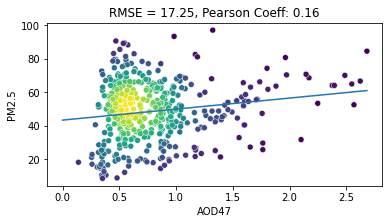

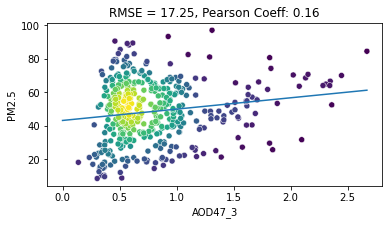

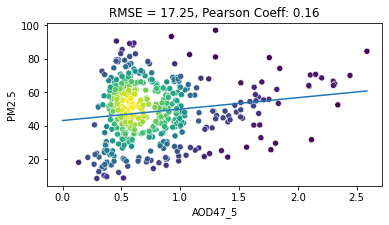

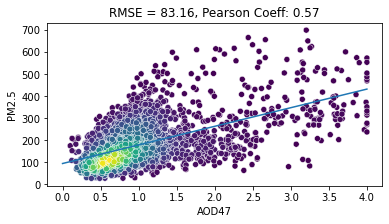

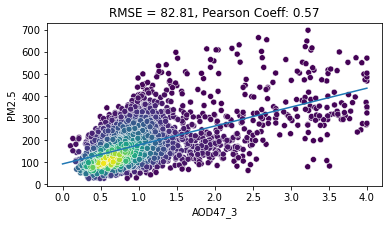

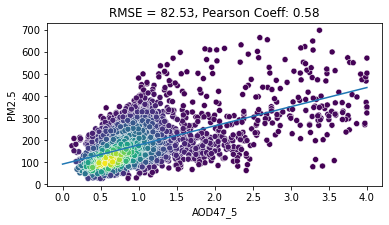

In [7]:
import seaborn as sns
from scipy import stats
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


def stat_info(doi, str_x, str_y):
    """
    doi: data of interest
    str_x: string name of input variable
    str_y: string name of varaible to be predicted

    returns: pearson coefficient, rmse
    """
    inp = doi[doi[[str_y, str_x]].isna().any(axis= 1) == False]
    y,x = (inp[str_y], inp[str_x])
    pr = stats.pearsonr(x, y)[0]
    a = stats.linregress(x,y)
    y_pred = x*a[0] + a[1]
    sp =stats.spearmanr(x,y)
    rmse = mean_squared_error(y, y_pred , squared=False)
    return rmse, pr , sp[0]

def reg_plot_auto(doi, str_x, str_y):
    # plt.figure()
    # a = sns.regplot(data=doi, x = str_x, y = str_y)
    # rmse, pr, sp = stat_info(doi, str_x, str_y)
    # plt.title('RMSE = {:.2f}, Pearson Coeff: {:.2f}'.format(rmse, pr))

    
   
    doi =doi[doi[[str_x, str_y]].isna().any(axis=1) == False]
    X = doi[str_x].to_numpy().reshape(-1, 1)
    Y = doi[str_y].to_numpy().reshape(-1, 1)

    values = np.vstack([doi[str_x], doi[str_y]])
    kernel = stats.gaussian_kde(values)(values)
    rmse, pr, sp = stat_info(doi, str_x, str_y)
    reg = LinearRegression().fit(X, Y)

    
    fig, ax = plt.subplots(figsize=(6, 3))
    x = np.linspace(0, doi[str_x].max(), 500)
    y = reg.predict(x.reshape(-1, 1))
    plt.plot(x, y)
    plt.title('RMSE = {:.2f}, Pearson Coeff: {:.2f}'.format(rmse, pr))
    sns.scatterplot(
        data=doi,
        x=str_x,
        y=str_y,
        c=kernel,
        cmap="viridis",
        ax=ax,
    )

#     fig, ax = plt.subplots(figsize=(6, 6))
#     ax = fig.add_subplot( projection='scatter_density')
#     density = ax.scatter_density(doi[str_x], doi[str_y], cmap=white_viridis, dpi =40)
#     fig.colorbar(density, label='Number of points per pixel')

# white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
#                     (0, '#ffffff'),
#                     (1e-20, '#440053'),
#                     (0.2, '#404388'),
#                     (0.4, '#2a788e'),
#                     (0.6, '#21a784'),
#                     (0.8, '#78d151'),
#                     (1, '#fde624'),
#                     ], N=256)


def auto_stat(doi):
    
    reg_plot_auto(doi, 'AOD47', 'PM2.5')
    reg_plot_auto(doi, 'AOD47_3', 'PM2.5')
    reg_plot_auto(doi, 'AOD47_5', 'PM2.5')
    #reg_plot_auto(doi, 'ColumnWV', 'PM2.5')
    #reg_plot_auto(doi, 'ColumnWV', 'RH')
    # reg_plot_auto(doi, 'NOx', 'PM2.5')
    # reg_plot_auto(doi, 'CO', 'PM2.5')
    #reg_plot_auto(doi, 'RH', 'PM2.5')
    # reg_plot_auto(doi, 'NH3', 'PM2.5')


    ##################### correlation map based on 1 month cpcb + aod data #####################
    # plt.figure(figsize = (12,12))
    # sns.heatmap(doi.iloc[:, 10:].corr(), cmap="YlGnBu", annot=True)
    
auto_stat(df)
auto_stat(df[df['season'] == 1])
auto_stat(df[df['season'] == 2])
auto_stat(df[df['season'] == 3])
auto_stat(df[df['season'] == 4])








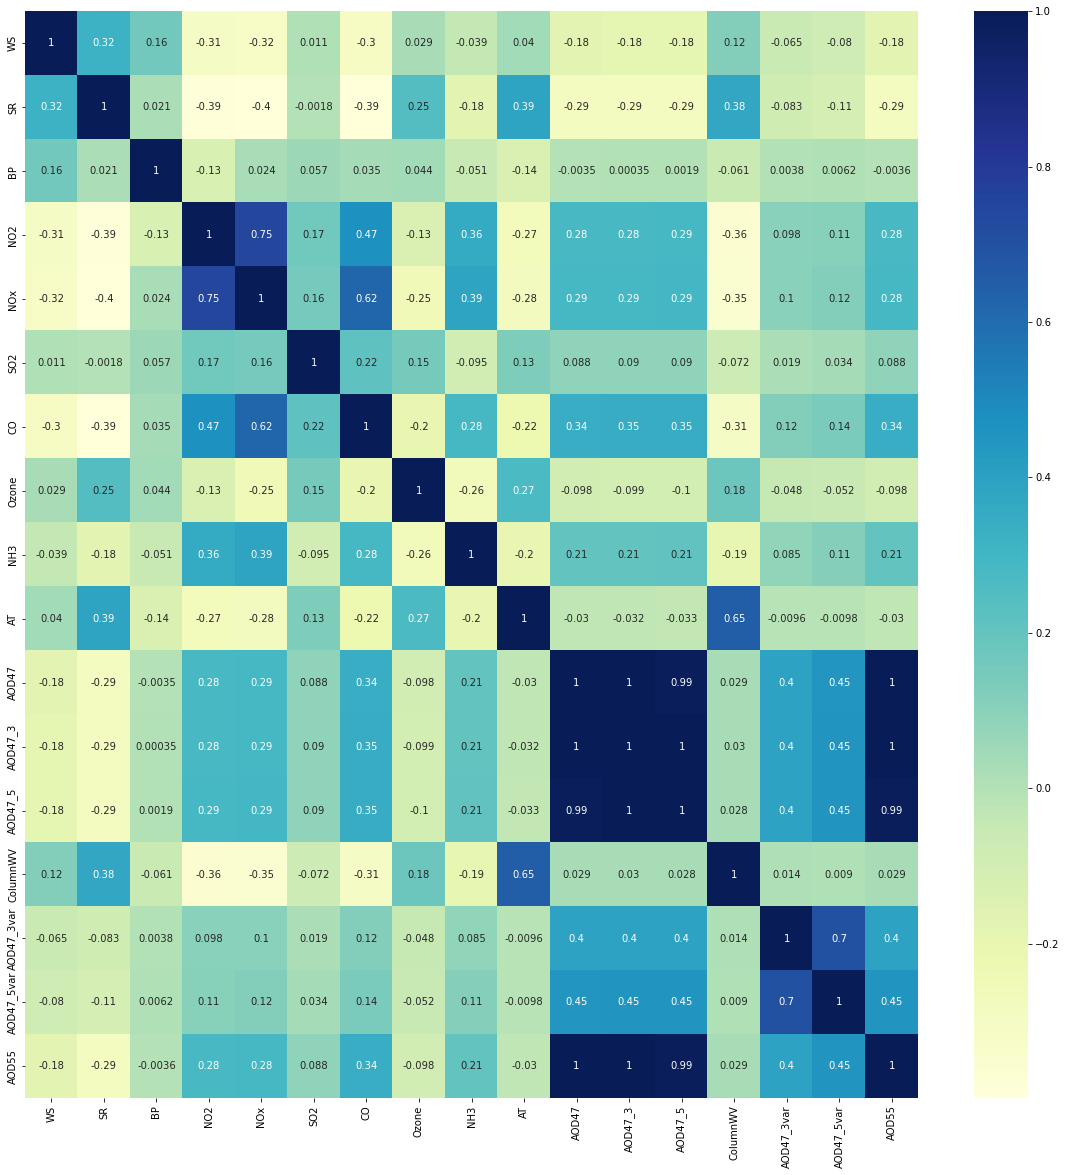

In [9]:
##################### correlation map based on 2 year cpcb data #####################
plt.figure(figsize = (20,20))
sns.heatmap(df.iloc[:, 13:].corr(), cmap="YlGnBu", annot=True)